In [1]:
from tvb.simulator.models.oscillator import Generic2dOscillator
from tvb.simulator.integrators import HeunStochastic
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import pymc3 as pm
import scipy
import theano.tensor as tt
import theano
import math
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Parameters
a_sim = -2.0
b_sim = -10.0
c_sim = 0.0
d_sim = 0.02
I_sim = 0.0

In [3]:
# TVB model and integrator setup
oscillator_model = Generic2dOscillator(
    a=np.asarray([a_sim]),
    b=np.asarray([b_sim]),
    c=np.asarray([c_sim]),
    d=np.asarray([d_sim]),
    I=np.asarray([I_sim]),
)
oscillator_model.configure()

integrator = HeunStochastic(dt=0.1)
integrator.noise.configure()
integrator.noise.configure_white(dt=integrator.dt)
integrator.set_random_state(random_state=None)
integrator.configure()
integrator.configure_boundaries(oscillator_model)

In [4]:
simulation_length = 100
stimulus = 0.0
local_coupling = 0.0

current_state_v = np.random.uniform(low=-2.0, high=4.0, size=[1, 1, 1])
current_state_w = np.random.uniform(low=-6.0, high=6.0, size=[1, 1, 1])
current_state = np.vstack([current_state_v, current_state_w])
state = current_state

current_step = 0
number_of_nodes = 1
start_step = current_step + 1
node_coupling = np.zeros([2, 1, 1])
n_steps = int(math.ceil(simulation_length / integrator.dt))

X = [current_state.copy()]
for step in range(start_step, start_step + n_steps):
    state = integrator.integrate(state, oscillator_model, node_coupling, local_coupling, stimulus)
    X.append(state.copy())

X = np.asarray(X)
t = np.linspace(0, simulation_length, n_steps + 1)

In [5]:
x_observed = np.random.normal(X, 1.)

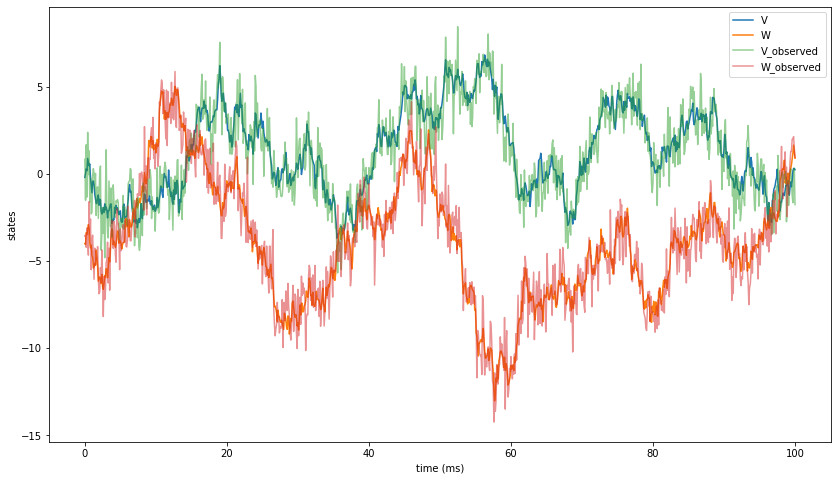

In [6]:
f1 = plt.figure(figsize=(14,8))
plt.plot(t, X[:, 0, 0, 0], label="V")
plt.plot(t, X[:, 1, 0, 0], label="W")
plt.plot(t, x_observed[:, 0, 0, 0], alpha=0.5, label="V_observed")
plt.plot(t, x_observed[:, 1, 0, 0], alpha=0.5, label="W_observed")
#plt.plot(observation["time"], observation["states"][:, 0, 0, 0], label="observation")
#plt.plot(observation["time"], noisy_observation[:, 0, 0, 0], alpha=0.5, label="noisy observation")
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.legend()
plt.show()

In [7]:
# global inference parameters
shape = x_observed.shape
draws = 1000
tune = 1000

### Inference using non-centered model

In [8]:
from tvb.contrib.inversion.pymcInference import NonCenteredModel

In [9]:
ncModel = NonCenteredModel(oscillator_model)

In [ ]:
# noise for each state variable
state_variable_noise = {
    0: 1.0,
    1: 0.0
}

In [10]:
with ncModel.pymc_model:
    a_star = pm.Normal("a_star", mu=0.0, sd=1.0)
    a = pm.Deterministic("a", -2.0 + 0.1 * a_star)
    
    b_star = pm.Normal("b_star", mu=0.0, sd=1.0)
    b = pm.Deterministic("b", -10.0 + 0.1 * b_star)
    
    c_star = pm.Normal("c_star", mu=0.0, sd=1.0)
    c = pm.Deterministic("c", 0.0 + 0.1 * c_star)
    
    d_star = pm.Normal("d_star", mu=0.0, sd=1.0)
    d = pm.Deterministic("d", 0.02 + 0.001 * d_star)
    
    I_star = pm.Normal("I_star", mu=0.0, sd=1.0)
    I = pm.Deterministic("I", 0.0 + 0.1 * I_star)
    
    # Passing the prior distributions as dictionary. Also including fixed model parameters.
    priors = {
        "a": a,
        "b": b,
        "c": c,
        "d": d,
        "I": I,
        "tau": np.array([1.0]),
        "e": np.array([3.0]),
        "f": np.array([1.0]),
        "g": np.array([0.0]),
        "alpha": np.array([1.0]),
        "beta": np.array([1.0]),
        "gamma": np.array([1.0])
    }
    
    consts = {"coupling": node_coupling, 
              "local_coupling": local_coupling}
    
    obs = {"x_obs": x_observed}
    
    time_step = integrator.dt
    
    x_init_star = pm.Normal("x_init_star", mu=0.0, sd=1.0, shape=shape[1:])
    x_init = pm.Deterministic("x_init", 0.0 + x_init_star)
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    noise = BoundedNormal("noise", mu=0.0, sd=1.0)
    
    amplitude_star = pm.Normal("amplitude_star", mu=0.0, sd=1.0)
    amplitude = pm.Deterministic("amplitude", 1.0 + amplitude_star)
    
    offset_star = pm.Normal("offset_star", mu=0.0, sd=1.0)
    offset = pm.Deterministic("offset", 0.0 + offset_star)
    
    epsilon = BoundedNormal("epsilon", mu=0.0, sd=1.0)

In [11]:
ncModel.set_model(priors, consts, obs, time_step, x_init, noise, amplitude, offset, epsilon, shape)

In [ ]:
nc_data = ncModel.run_inference(draws=draws, tune=tune, cores=1, target_accept=0.9)

/Users/erichter/opt/anaconda3/envs/BrainSim-env/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


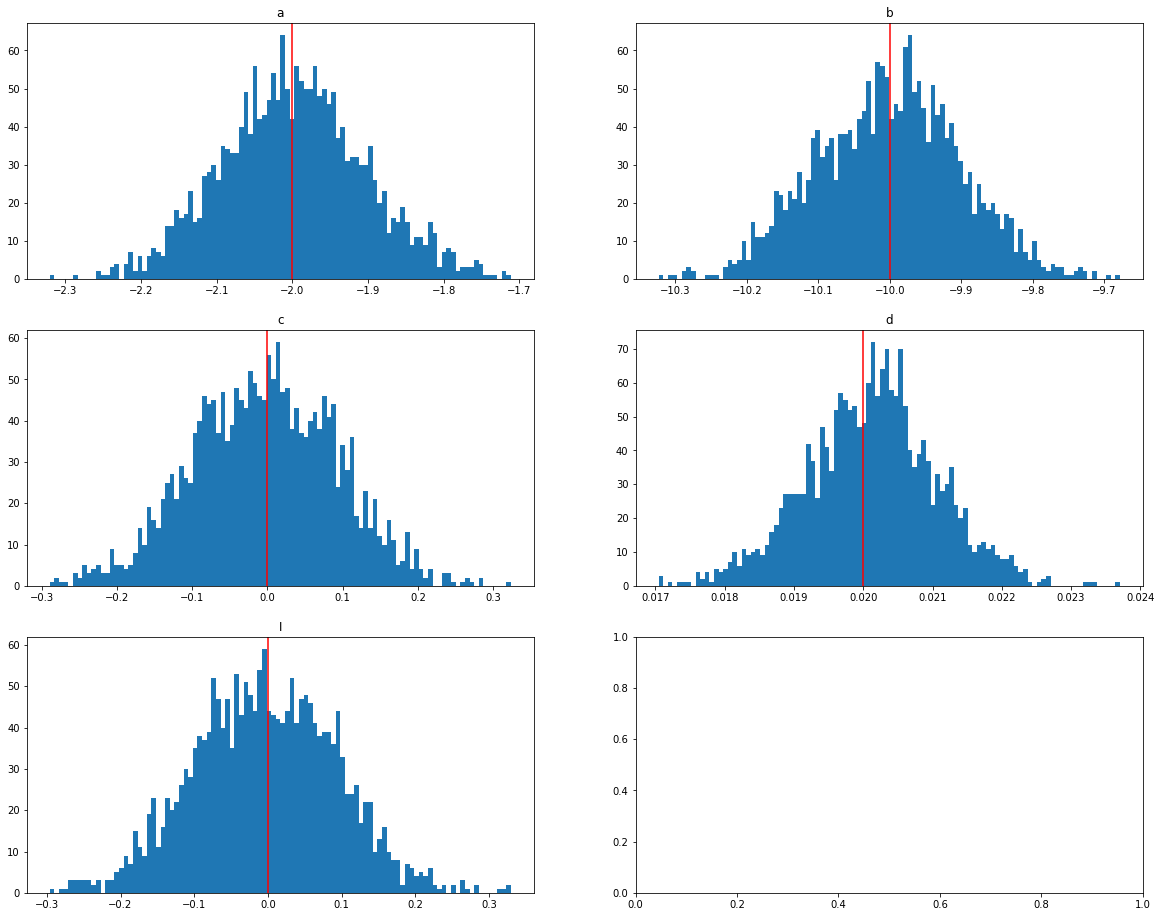

In [16]:
ncModel.plot_posterior(init_params={"a": a_sim, "b": b_sim, "c": c_sim, "d": d_sim, "I": I_sim})

In [22]:
nc_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [23]:
posterior_x_obs = nc_data.posterior_predictive.x_obs.values.reshape((draws + tune, *shape))
posterior_x_hat = nc_data.posterior.x_hat.values.reshape((draws + tune, *shape))

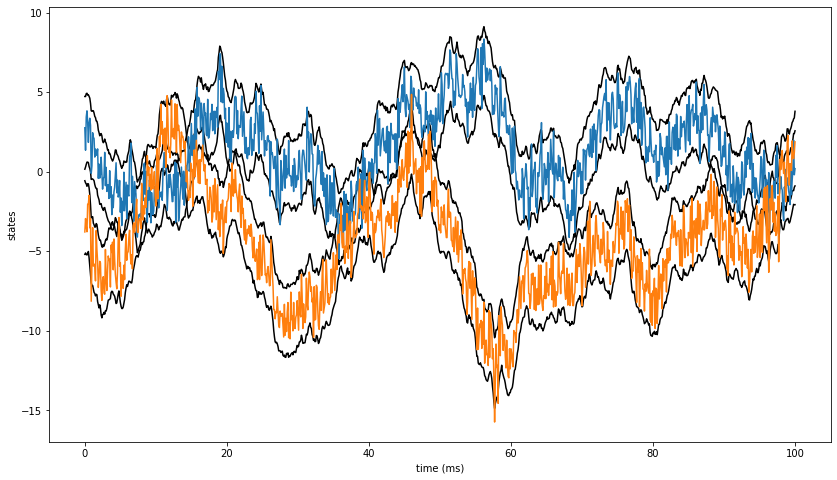

In [24]:
f3 = plt.figure(figsize=(14,8))
plt.plot(t, np.percentile(posterior_x_obs[:, :, 0, 0, 0], [2.5, 97.5], axis=0).T, 
         "k", label=r"$V_{95\% PP}(t)$")
plt.plot(t, np.percentile(posterior_x_obs[:, :, 1, 0, 0], [2.5, 97.5], axis=0).T, 
         "k", label=r"$W_{95\% PP}(t)$")
plt.plot(t, x_observed[:, 0, 0, 0], label="V_observed")
plt.plot(t, x_observed[:, 1, 0, 0], label="W_observed")
#plt.legend(fontsize=15)
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()

In [25]:
criteria = ncModel.model_criteria(["WAIC", "LOO"])

/Users/erichter/opt/anaconda3/envs/BrainSim-env/lib/python3.7/site-packages/arviz/stats/stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/Users/erichter/opt/anaconda3/envs/BrainSim-env/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


In [26]:
print("WAIC: ", criteria["WAIC"])
print("LOO: ", criteria["LOO"])

WAIC:  6137.914800761283
LOO:  6168.006626072613


In [27]:
log_likelihood = nc_data.log_likelihood.x_obs.values.reshape((draws + tune, *shape))

In [28]:
with ncModel.pymc_model:
    map_estimate = pm.find_MAP()

In [29]:
ncModel.summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_star,0.016,1.009,-1.835,1.980,0.015,0.026,4507.0,1340.0,1.00
b_star,-0.001,0.958,-1.919,1.702,0.015,0.025,4063.0,1324.0,1.00
c_star,0.017,0.938,-1.668,1.773,0.014,0.022,4576.0,1529.0,1.00
d_star,-0.061,1.056,-2.020,1.846,0.103,0.073,103.0,1310.0,1.02
I_star,-0.041,1.015,-2.049,1.754,0.016,0.028,4022.0,1120.0,1.01
...,...,...,...,...,...,...,...,...,...
"x_hat[998, 1, 0, 0]",1.123,0.492,0.193,2.065,0.010,0.007,2670.0,1750.0,1.00
"x_hat[999, 0, 0, 0]",0.145,0.514,-0.804,1.107,0.010,0.008,2434.0,1941.0,1.00
"x_hat[999, 1, 0, 0]",1.216,0.522,0.296,2.192,0.010,0.007,2577.0,1848.0,1.00
"x_hat[1000, 0, 0, 0]",0.154,0.574,-0.927,1.196,0.012,0.010,2532.0,1943.0,1.00


In [30]:
divergent = ncModel.trace["diverging"]
print("Number of Divergent %d" % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(ncModel.trace) * 100
print("Percentage of Divergent %.1f" % divperc)
print("Mean tree accept %.1f" % ncModel.trace['mean_tree_accept'].mean())

Number of Divergent 11
Percentage of Divergent 1.1
Mean tree accept 0.9


### Inference using centered model

In [31]:
from tvb.contrib.inversion.pymcInference import CenteredModel

In [44]:
cModel = CenteredModel(oscillator_model)

In [45]:
with cModel.pymc_model:
    a = pm.Normal("a", mu=-2.0, sd=1.0)
    
    b = pm.Normal("b", mu=-10.0, sd=1.0)
    
    c = pm.Normal("c", mu=0.0, sd=1.0)
    
    d = pm.Normal("d", mu=0.02, sd=1.0)
    
    I = pm.Normal("I", mu=0.0, sd=1.0)
    
    # Passing the prior distributions as dictionary. Also including fixed model parameters.
    priors = {
        "a": a,
        "b": b,
        "c": c,
        "d": d,
        "I": I,
        "tau": np.array([1.0]),
        "e": np.array([3.0]),
        "f": np.array([1.0]),
        "g": np.array([0.0]),
        "alpha": np.array([1.0]),
        "beta": np.array([1.0]),
        "gamma": np.array([1.0])
    }
    
    consts = {"coupling": node_coupling, 
              "local_coupling": local_coupling}
    
    obs = {"x_obs": x_observed}
    
    time_step = integrator.dt
    
    x_init = pm.Normal("x_init", mu=0.0, sd=1.0, shape=shape[1:])
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    noise = BoundedNormal("noise", mu=0.0, sd=1.0)
    
    amplitude = pm.Normal("amplitude", mu=1.0, sd=1.0)
    
    offset = pm.Normal("offset", mu=0.0, sd=1.0)
    
    epsilon = BoundedNormal("epsilon", mu=0.0, sd=1.0)

In [46]:
cModel.set_model(priors, consts, obs, time_step, x_init, noise, amplitude, offset, epsilon, shape)

In [47]:
c_data = cModel.run_inference(draws=draws, tune=tune, cores=1, target_accept=0.9)

ValueError: Not enough samples to build a trace.

In [ ]:
cModel.plot_posterior(init_params={"a": a_sim, "b": b_sim, "c": c_sim, "d": d_sim, "I": I_sim})

In [ ]:
posterior_x_obs = c_data.posterior_predictive.x_obs.values.reshape((draws + tune, *shape))

In [ ]:
f5 = plt.figure(figsize=(14,8))
plt.plot(t, np.percentile(posterior_x_obs[:, :, 0, 0, 0], [2.5, 97.5], axis=0).T, 
         "k", label=r"$V_{95\% PP}(t)$")
plt.plot(t, np.percentile(posterior_x_obs[:, :, 1, 0, 0], [2.5, 97.5], axis=0).T, 
         "k", label=r"$W_{95\% PP}(t)$")
plt.plot(t, x_observed[:, 0, 0, 0], label="V_observed")
plt.plot(t, x_observed[:, 1, 0, 0], label="W_observed")
#plt.legend(fontsize=15)
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()

In [ ]:
criteria = cModel.model_criteria(["WAIC", "LOO"])

In [ ]:
print("WAIC: ", criteria["WAIC"])
print("LOO: ", criteria["LOO"])

In [ ]:
log_likelihood = c_data.log_likelihood.x_obs.values.reshape((draws + tune, shape[0]))

In [ ]:
with cModel.pymc_model:
    map_estimate = pm.find_MAP()

In [ ]:
map_estimate

In [ ]:
cModel.summary

In [ ]:
divergent = cModel.trace["diverging"]
print("Number of Divergent %d" % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(cModel.trace) * 100
print("Percentage of Divergent %.1f" % divperc)
print("Mean tree accept %.1f" % cModel.trace['mean_tree_accept'].mean())